# Riccati experiments

Notebook for Riccati experiments.

**Author:** [Benjamin Carrel](benjamin.carrel@unige.ch)

## Compare the methods - Global error and performance

### Setup the problem

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matrix_ode_toolbox.integrate import solve_matrix_ivp
from matrix_ode_toolbox.dlra import solve_dlra
from problems import make_riccati_ostermann
from low_rank_toolbox import SVD, LowRankMatrix
import scipy.sparse.linalg as spala
import time

# Problem parameters
size = 200 # 200
q = 9 # 9
t_span = (0, 0.1) # (0, 0.1)
make_ode = lambda size: make_riccati_ostermann(size, q)
ode, X0 = make_ode(size)

# Print the ode
print(ode)

# Preprocess the problem
if not isinstance(X0, LowRankMatrix):
    X0 = SVD.reduced_svd(X0)
invA = spala.splu(ode.A).solve
invB = spala.splu(ode.B).solve

Riccati ODE structure with 3 parameters.


### Setup the solvers

In [6]:
# DLRA parameters
rank = 20 # 20
Y0 = X0.truncate(rank)

# Methods parameters - ALL PERK
nb_steps = np.logspace(1, 4, 8, dtype=int) # np.logspace(1, 4, 8, dtype=int)
stepsizes = t_span[1] / nb_steps
dlra_solvers = ['PERK', 'PERK', 'low_rank_splitting', 'low_rank_splitting']
krylov_kwargs = {'size': 1,
                 'kind': 'extended',
                 'is_symmetric': True,
                 'invA': invA,
                 'invB': invB}
methods_kwargs = [{'order': 1, 'krylov_kwargs': krylov_kwargs},
                  {'order': 2, 'krylov_kwargs': krylov_kwargs, 'strict_order_conditions': True},
                  {'order': 1},
                  {'order': 2}]

## Pre-allocate some variables
global_errors = np.zeros((len(nb_steps), len(dlra_solvers)))
times = np.zeros((len(nb_steps), len(dlra_solvers)))

### Run the solvers

In [7]:
# Loop over the number of steps
for i, nb in enumerate(nb_steps):
    print('*************************************************************************')
    print(f'Solving with {nb} steps. ({i+1}/{len(nb_steps)})')
    t_eval = np.linspace(*t_span, nb+1)

    # Compute the reference solution
    X1 = solve_matrix_ivp(ode, t_span, X0, solver="automatic", t_eval=t_eval, dense_output=True, monitor=True).X1
    
    # Loop over the methods
    for j, method in enumerate(dlra_solvers):
        # Compute the solution with the current method
        t0 = time.time()
        Y1 = solve_dlra(ode, t_span, Y0, dlra_solver=method, t_eval=t_eval, monitor=True, solver_kwargs=methods_kwargs[j]).X1
        times[i, j] = time.time() - t0

        # Compute the relative error
        global_errors[i, j] = np.linalg.norm(Y1.todense() - X1, 'fro') / np.linalg.norm(X1, 'fro')

# Approximate error
approx_error = np.linalg.norm(X1 - SVD.truncated_svd(X1, rank).todense(), 'fro') / np.linalg.norm(X1, 'fro')

*************************************************************************
Solving with 10 steps. (1/6)
----------------------------------------
Scipy solver 
-- RK45 method 
-- 1 substep(s)


Solving matrix ODE: 100%|██████████| 10/10 [00:01<00:00,  7.72it/s]


----------------------------------------
Projected exponential Runge-Kutta (PERK) 
-- 1 stage(s) 
-- Strict order conditions: True 
-- 1 substep(s) 
-- extended Krylov space and 1 iteration(s) 
-- Largest matrix shape: (4*rank, 4*rank)


Solving DLRA: 100%|██████████| 10/10 [00:00<00:00, 23.60it/s]


----------------------------------------
Projected exponential Runge-Kutta (PERK) 
-- 2 stage(s) 
-- Strict order conditions: True 
-- 1 substep(s) 
-- extended Krylov space and 1 iteration(s) 
-- Largest matrix shape: (8*rank, 8*rank)


Solving DLRA: 100%|██████████| 10/10 [00:00<00:00, 11.40it/s]


----------------------------------------
Low-rank splitting (Ostermann et al. 2019) 
-- Order 1 splitting (Lie-Trotter) 
-- 1 substep(s) 
-- Projector splitting (KSL) as low-rank solver


Solving DLRA: 100%|██████████| 10/10 [00:00<00:00, 33.07it/s]


----------------------------------------
Low-rank splitting (Ostermann et al. 2019) 
-- Order 2 splitting (Strang) 
-- 1 substep(s) 
-- Projector splitting (KSL) as low-rank solver


Solving DLRA: 100%|██████████| 10/10 [00:00<00:00, 31.07it/s]


*************************************************************************
Solving with 25 steps. (2/6)
----------------------------------------
Scipy solver 
-- RK45 method 
-- 1 substep(s)


Solving matrix ODE: 100%|██████████| 25/25 [00:01<00:00, 19.37it/s]


----------------------------------------
Projected exponential Runge-Kutta (PERK) 
-- 1 stage(s) 
-- Strict order conditions: True 
-- 1 substep(s) 
-- extended Krylov space and 1 iteration(s) 
-- Largest matrix shape: (4*rank, 4*rank)


Solving DLRA: 100%|██████████| 25/25 [00:00<00:00, 42.38it/s]


----------------------------------------
Projected exponential Runge-Kutta (PERK) 
-- 2 stage(s) 
-- Strict order conditions: True 
-- 1 substep(s) 
-- extended Krylov space and 1 iteration(s) 
-- Largest matrix shape: (8*rank, 8*rank)


Solving DLRA: 100%|██████████| 25/25 [00:01<00:00, 18.41it/s]


----------------------------------------
Low-rank splitting (Ostermann et al. 2019) 
-- Order 1 splitting (Lie-Trotter) 
-- 1 substep(s) 
-- Projector splitting (KSL) as low-rank solver


Solving DLRA: 100%|██████████| 25/25 [00:00<00:00, 60.77it/s]


----------------------------------------
Low-rank splitting (Ostermann et al. 2019) 
-- Order 2 splitting (Strang) 
-- 1 substep(s) 
-- Projector splitting (KSL) as low-rank solver


Solving DLRA: 100%|██████████| 25/25 [00:00<00:00, 49.06it/s]


*************************************************************************
Solving with 63 steps. (3/6)
----------------------------------------
Scipy solver 
-- RK45 method 
-- 1 substep(s)


Solving matrix ODE: 100%|██████████| 63/63 [00:01<00:00, 42.56it/s]


----------------------------------------
Projected exponential Runge-Kutta (PERK) 
-- 1 stage(s) 
-- Strict order conditions: True 
-- 1 substep(s) 
-- extended Krylov space and 1 iteration(s) 
-- Largest matrix shape: (4*rank, 4*rank)


Solving DLRA: 100%|██████████| 63/63 [00:01<00:00, 56.53it/s]


----------------------------------------
Projected exponential Runge-Kutta (PERK) 
-- 2 stage(s) 
-- Strict order conditions: True 
-- 1 substep(s) 
-- extended Krylov space and 1 iteration(s) 
-- Largest matrix shape: (8*rank, 8*rank)


Solving DLRA: 100%|██████████| 63/63 [00:02<00:00, 26.20it/s]


----------------------------------------
Low-rank splitting (Ostermann et al. 2019) 
-- Order 1 splitting (Lie-Trotter) 
-- 1 substep(s) 
-- Projector splitting (KSL) as low-rank solver


Solving DLRA: 100%|██████████| 63/63 [00:00<00:00, 89.14it/s]


----------------------------------------
Low-rank splitting (Ostermann et al. 2019) 
-- Order 2 splitting (Strang) 
-- 1 substep(s) 
-- Projector splitting (KSL) as low-rank solver


Solving DLRA: 100%|██████████| 63/63 [00:00<00:00, 80.43it/s]


*************************************************************************
Solving with 158 steps. (4/6)
----------------------------------------
Scipy solver 
-- RK45 method 
-- 1 substep(s)


Solving matrix ODE: 100%|██████████| 158/158 [00:01<00:00, 107.32it/s]


----------------------------------------
Projected exponential Runge-Kutta (PERK) 
-- 1 stage(s) 
-- Strict order conditions: True 
-- 1 substep(s) 
-- extended Krylov space and 1 iteration(s) 
-- Largest matrix shape: (4*rank, 4*rank)


Solving DLRA: 100%|██████████| 158/158 [00:02<00:00, 67.00it/s]


----------------------------------------
Projected exponential Runge-Kutta (PERK) 
-- 2 stage(s) 
-- Strict order conditions: True 
-- 1 substep(s) 
-- extended Krylov space and 1 iteration(s) 
-- Largest matrix shape: (8*rank, 8*rank)


Solving DLRA: 100%|██████████| 158/158 [00:05<00:00, 29.81it/s]


----------------------------------------
Low-rank splitting (Ostermann et al. 2019) 
-- Order 1 splitting (Lie-Trotter) 
-- 1 substep(s) 
-- Projector splitting (KSL) as low-rank solver


Solving DLRA: 100%|██████████| 158/158 [00:01<00:00, 116.90it/s]


----------------------------------------
Low-rank splitting (Ostermann et al. 2019) 
-- Order 2 splitting (Strang) 
-- 1 substep(s) 
-- Projector splitting (KSL) as low-rank solver


Solving DLRA: 100%|██████████| 158/158 [00:01<00:00, 95.15it/s]


*************************************************************************
Solving with 398 steps. (5/6)
----------------------------------------
Scipy solver 
-- RK45 method 
-- 1 substep(s)


Solving matrix ODE: 100%|██████████| 398/398 [00:01<00:00, 226.36it/s]


----------------------------------------
Projected exponential Runge-Kutta (PERK) 
-- 1 stage(s) 
-- Strict order conditions: True 
-- 1 substep(s) 
-- extended Krylov space and 1 iteration(s) 
-- Largest matrix shape: (4*rank, 4*rank)


Solving DLRA: 100%|██████████| 398/398 [00:05<00:00, 76.47it/s]


----------------------------------------
Projected exponential Runge-Kutta (PERK) 
-- 2 stage(s) 
-- Strict order conditions: True 
-- 1 substep(s) 
-- extended Krylov space and 1 iteration(s) 
-- Largest matrix shape: (8*rank, 8*rank)


Solving DLRA: 100%|██████████| 398/398 [00:12<00:00, 32.60it/s]


----------------------------------------
Low-rank splitting (Ostermann et al. 2019) 
-- Order 1 splitting (Lie-Trotter) 
-- 1 substep(s) 
-- Projector splitting (KSL) as low-rank solver


Solving DLRA: 100%|██████████| 398/398 [00:02<00:00, 133.21it/s]


----------------------------------------
Low-rank splitting (Ostermann et al. 2019) 
-- Order 2 splitting (Strang) 
-- 1 substep(s) 
-- Projector splitting (KSL) as low-rank solver


Solving DLRA: 100%|██████████| 398/398 [00:03<00:00, 105.59it/s]


*************************************************************************
Solving with 1000 steps. (6/6)
----------------------------------------
Scipy solver 
-- RK45 method 
-- 1 substep(s)


Solving matrix ODE: 100%|██████████| 1000/1000 [00:02<00:00, 494.13it/s]


----------------------------------------
Projected exponential Runge-Kutta (PERK) 
-- 1 stage(s) 
-- Strict order conditions: True 
-- 1 substep(s) 
-- extended Krylov space and 1 iteration(s) 
-- Largest matrix shape: (4*rank, 4*rank)


Solving DLRA: 100%|██████████| 1000/1000 [00:12<00:00, 78.99it/s]


----------------------------------------
Projected exponential Runge-Kutta (PERK) 
-- 2 stage(s) 
-- Strict order conditions: True 
-- 1 substep(s) 
-- extended Krylov space and 1 iteration(s) 
-- Largest matrix shape: (8*rank, 8*rank)


Solving DLRA: 100%|██████████| 1000/1000 [00:29<00:00, 33.40it/s]


----------------------------------------
Low-rank splitting (Ostermann et al. 2019) 
-- Order 1 splitting (Lie-Trotter) 
-- 1 substep(s) 
-- Projector splitting (KSL) as low-rank solver


Solving DLRA: 100%|██████████| 1000/1000 [00:03<00:00, 311.66it/s]


----------------------------------------
Low-rank splitting (Ostermann et al. 2019) 
-- Order 2 splitting (Strang) 
-- 1 substep(s) 
-- Projector splitting (KSL) as low-rank solver


Solving DLRA: 100%|██████████| 1000/1000 [00:05<00:00, 196.69it/s]


### Plot the comparison with the low-rank splitting method

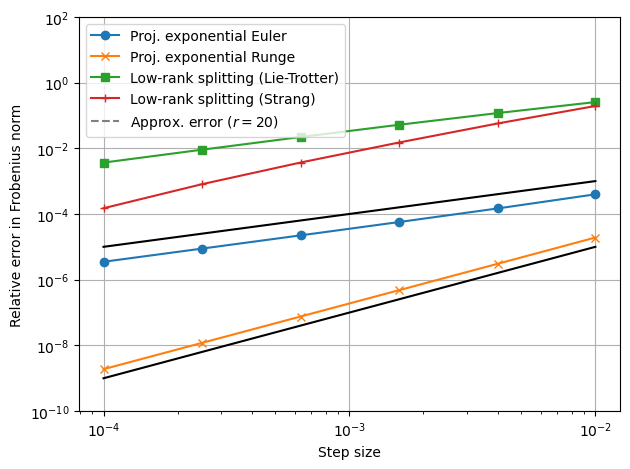

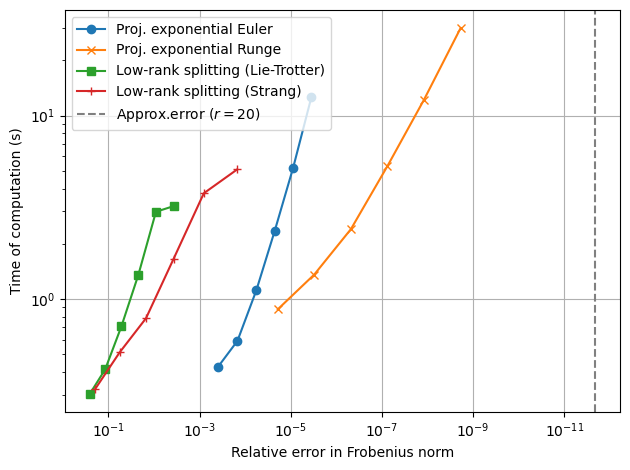

In [13]:
# Plot the errors
fig1 = plt.figure()
method_names = ['Proj. exponential Euler', 'Proj. exponential Runge', 'Low-rank splitting (Lie-Trotter)', 'Low-rank splitting (Strang)']
styles = ['-o', '-x', '-s', '-+']
plt.loglog(stepsizes, global_errors[:, 0], styles[0], label=method_names[0])
plt.loglog(stepsizes, global_errors[:, 1], styles[1], label=method_names[1])
plt.loglog(stepsizes, global_errors[:, 2], styles[2], label=method_names[2])
plt.loglog(stepsizes, global_errors[:, 3], styles[3], label=method_names[3])
plt.loglog(stepsizes, 1e-1*stepsizes, 'k') # , label=r'$O(h)$'
plt.loglog(stepsizes, 1e-1*stepsizes**2, 'k') # , label=r'$O(h^2)$'
plt.axhline(approx_error, linestyle='--', color='gray', label=f'Approx. error ($r={rank}$)')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel("Step size")
plt.ylabel("Relative error in Frobenius norm")
plt.ylim([1e-10, 1e2])
plt.tight_layout()
plt.show()


# Plot the performance
fig2 = plt.figure()
plt.loglog(global_errors[:, 0], times[:, 0], styles[0], label=method_names[0])
plt.loglog(global_errors[:, 1], times[:, 1], styles[1], label=method_names[1])
plt.loglog(global_errors[:, 2], times[:, 2], styles[2], label=method_names[2])
plt.loglog(global_errors[:, 3], times[:, 3], styles[3], label=method_names[3])
plt.axvline(approx_error, linestyle='--', color='gray', label=f'Approx.error ($r={rank}$)')
plt.legend(loc='upper left')
plt.gca().invert_xaxis()
plt.grid()
plt.xlabel("Relative error in Frobenius norm")
plt.ylabel("Time of computation (s)")
plt.tight_layout()
plt.show()

## Krylov approximation error - Order one

### Setup the problem

In [53]:
# Imports
import numpy as np
import scipy.linalg as la
from problems import make_riccati_ostermann
from low_rank_toolbox import SVD, LowRankMatrix
import scipy.sparse.linalg as spala
import matplotlib.pyplot as plt
from krylov_toolbox import KrylovSpace, ExtendedKrylovSpace, RationalKrylovSpace


# Problem parameters
size = 200 # 200
q = 9 # 9
make_ode = lambda size: make_riccati_ostermann(size, q)
ode, X0 = make_ode(size)

# Krylov parameters
t_span = (0, 0.01) # (0, 0.01)
h = t_span[1] - t_span[0]
rank = 2 # rank of initial value
nb_krylov_iter = 10 # number of Krylov iterations (extended Krylov space will have size 2*nb_krylov_iter)

# Print the ode
print(ode)

# Preprocess the problem
if not isinstance(X0, LowRankMatrix):
    X0 = SVD.reduced_svd(X0)
invA = spala.splu(ode.A).solve
invB = spala.splu(ode.B).solve

# Closed-form solution
def closed_form_solver(h, A, B, Y0, PGY0):
    # Solve the reduced problem (closed form)
    C = la.solve_sylvester(A, B, PGY0.todense())
    Z = Y0 + C
    Z = spala.expm_multiply(A, Z, start=0, stop=h, num=2, endpoint=True)[-1]
    Z = spala.expm_multiply(B.T.conj(), Z.T.conj(), start=0, stop=h, num=2, endpoint=True)[-1].T.conj()
    return Z - C

Riccati ODE structure with 3 parameters.


### Full problem

In [54]:
# Full data
A = ode.A
Ad = ode.A.todense()
B = ode.B
Bd = ode.B.todense()
Y0 = SVD.truncated_svd(X0, rank)
PGY0 = Y0.project_onto_tangent_space(ode.non_linear_field(0, Y0))

# Solve the full problem (closed form)
C = la.solve_sylvester(Ad, Bd, PGY0.todense())
Z = Y0 + C
Z = spala.expm_multiply(A, Z, start=0, stop=h, num=2, endpoint=True)[-1]
Z = spala.expm_multiply(B.T.conj(), Z.T.conj(), start=0, stop=h, num=2, endpoint=True)[-1].T.conj()
Y1_full = Z - C

print('Done!')

Done!


### Reduced problem - Polynomial Krylov space

In [55]:
# Pre-allocate some variables
krylov_error = np.zeros(nb_krylov_iter)
krylov_space_size = np.zeros(nb_krylov_iter, dtype=int)

# Initialization of the two spaces
U = la.orth(np.column_stack([Y0.U, PGY0.U]))
left_krylov_space = KrylovSpace(A, U)
V = la.orth(np.column_stack([Y0.V, PGY0.V]))
right_krylov_space = KrylovSpace(B, V)

# Define the reduced problem ode
Vk = left_krylov_space.Q
Wk = right_krylov_space.Q
A_reduced = Vk.T.dot(A.dot(Vk))
B_reduced = Wk.T.dot(B.dot(Wk))
Y0_reduced = Y0.dot(Wk).dot(Vk.T, side='left')
PGY0_reduced = PGY0.dot(Wk).dot(Vk.T, side='left')

## Compute the solution
Zk = closed_form_solver(h, A_reduced, B_reduced, Y0_reduced, PGY0_reduced)
Y1_reduced = Vk.dot(Zk.dot(Wk.T))

# Compute the error and store the current size
krylov_error[0] = la.norm(Y1_full - Y1_reduced) / la.norm(Y1_full)
krylov_space_size[0] = left_krylov_space.Q.shape[1]
print("Iteration: k=0, size of space: {}, current error: {}".format(krylov_space_size[0], krylov_error[0]))

# Loop over the iterations
for i in np.arange(1, nb_krylov_iter):
    # Augment the two basis
    left_krylov_space.augment_basis()
    right_krylov_space.augment_basis()

    # Define the reduced problem ode
    Vk = left_krylov_space.Q
    Wk = right_krylov_space.Q
    A_reduced = Vk.T.dot(A.dot(Vk))
    B_reduced = Wk.T.dot(B.dot(Wk))
    Y0_reduced = Y0.dot(Wk).dot(Vk.T, side='left')
    PGY0_reduced = PGY0.dot(Wk).dot(Vk.T, side='left')
    
    # Compute the solution
    Zk = closed_form_solver(h, A_reduced, B_reduced, Y0_reduced, PGY0_reduced)
    Y1_reduced = Vk.dot(Zk.dot(Wk.T))

    # Compute the error and store the current size
    krylov_error[i] = la.norm(Y1_full - Y1_reduced) / la.norm(Y1_full)
    krylov_space_size[i] = left_krylov_space.Q.shape[1]
    print("Iteration: k={}, size of space: {}, current error: {}".format(i, krylov_space_size[i], krylov_error[i]))

print("Done!")

Iteration: k=0, size of space: 4, current error: 0.05222668022116764
Iteration: k=1, size of space: 8, current error: 0.005305788541086759
Iteration: k=2, size of space: 12, current error: 0.0029810204397282456
Iteration: k=3, size of space: 16, current error: 0.0020957801740932374
Iteration: k=4, size of space: 20, current error: 0.0020471014494259864
Iteration: k=5, size of space: 24, current error: 0.0005176992781481626
Iteration: k=6, size of space: 28, current error: 0.00019977888457732538
Iteration: k=7, size of space: 32, current error: 0.00017913528607180085
Iteration: k=8, size of space: 36, current error: 0.0001880881502343357
Iteration: k=9, size of space: 40, current error: 0.0001797116110095256
Done!


### Reduced problem - Extended Krylov space

In [56]:
# Pre-allocate some variables
nb_extended_krylov_iter = int(nb_krylov_iter/2)
extended_krylov_error = np.zeros(nb_extended_krylov_iter)
extended_krylov_space_size = np.zeros(nb_extended_krylov_iter, dtype=int)

# Preprocess the inverses
invA = spala.splu(ode.A).solve
invB = spala.splu(ode.B).solve

# Initialization of the two spaces
U = la.orth(np.column_stack([Y0.U, PGY0.U]))
left_extended_krylov_space = ExtendedKrylovSpace(A, U, invA=invA)
V = la.orth(np.column_stack([Y0.V, PGY0.V]))
right_extended_krylov_space = ExtendedKrylovSpace(B, V, invA=invB)

# Define the reduced problem ode
Vk = left_extended_krylov_space.Q
Wk = right_extended_krylov_space.Q
A_reduced = Vk.T.dot(A.dot(Vk))
B_reduced = Wk.T.dot(B.dot(Wk))
Y0_reduced = Y0.dot(Wk).dot(Vk.T, side='left')
PGY0_reduced = PGY0.dot(Wk).dot(Vk.T, side='left')

## Compute the solution
Zk = closed_form_solver(h, A_reduced, B_reduced, Y0_reduced, PGY0_reduced)
Y1_reduced = Vk.dot(Zk.dot(Wk.T))

# Compute the error and store the current size
extended_krylov_error[0] = la.norm(Y1_full - Y1_reduced) / la.norm(Y1_full)
extended_krylov_space_size[0] = left_extended_krylov_space.Q.shape[1]
print("Iteration: k={}, size of space: {}, current error: {}".format(0, extended_krylov_space_size[0], extended_krylov_error[0]))

# Loop over the iterations
for i in np.arange(1, nb_extended_krylov_iter):
    # Augment the two basis
    left_extended_krylov_space.augment_basis()
    right_extended_krylov_space.augment_basis()

    # Define the reduced problem ode
    Vk = left_extended_krylov_space.Q
    Wk = right_extended_krylov_space.Q
    A_reduced = Vk.T.dot(A.dot(Vk))
    B_reduced = Wk.T.dot(B.dot(Wk))
    Y0_reduced = Y0.dot(Wk).dot(Vk.T, side='left')
    PGY0_reduced = PGY0.dot(Wk).dot(Vk.T, side='left')
    
    # Compute the solution
    Zk = closed_form_solver(h, A_reduced, B_reduced, Y0_reduced, PGY0_reduced)
    Y1_reduced = Vk.dot(Zk.dot(Wk.T))

    # Compute the error and store the current size
    extended_krylov_error[i] = la.norm(Y1_full - Y1_reduced) / la.norm(Y1_full)
    extended_krylov_space_size[i] = left_extended_krylov_space.Q.shape[1]
    print("Iteration: k={}, size of space: {}, current error: {}".format(i, extended_krylov_space_size[i], extended_krylov_error[i]))

print("Done!")


Iteration: k=0, size of space: 8, current error: 0.0010409881197936018
Iteration: k=1, size of space: 16, current error: 1.2435137194108806e-06
Iteration: k=2, size of space: 24, current error: 5.1606527417835695e-09
Iteration: k=3, size of space: 32, current error: 1.1276273579223173e-11
Iteration: k=4, size of space: 40, current error: 1.1733357632394249e-12
Done!


### Reduced problem - Rational Krylov space

In [57]:
# Pre-allocate some variables
rational_krylov_error = np.zeros(nb_krylov_iter)
rational_krylov_space_size = np.zeros(nb_krylov_iter, dtype=int)

# One repeated single pole: k/sqrt(2)
poles = [nb_krylov_iter/np.sqrt(2) for _ in range(nb_krylov_iter)]

# Initialization of the two spaces
U = la.orth(np.column_stack([Y0.U, PGY0.U]))
left_rational_krylov_space = RationalKrylovSpace(A, U, poles=poles)
V = la.orth(np.column_stack([Y0.V, PGY0.V]))
right_rational_krylov_space = RationalKrylovSpace(B, V, poles=poles)

# Define the reduced problem ode
Vk = left_rational_krylov_space.Q
Wk = right_rational_krylov_space.Q
A_reduced = Vk.T.dot(A.dot(Vk))
B_reduced = Wk.T.dot(B.dot(Wk))
Y0_reduced = Y0.dot(Wk).dot(Vk.T, side='left')
PGY0_reduced = PGY0.dot(Wk).dot(Vk.T, side='left')

## Compute the solution
Zk = closed_form_solver(h, A_reduced, B_reduced, Y0_reduced, PGY0_reduced)
Y1_reduced = Vk.dot(Zk.dot(Wk.T))

# Compute the error and store the current size
rational_krylov_error[0] = la.norm(Y1_full - Y1_reduced) / la.norm(Y1_full)
rational_krylov_space_size[0] = left_rational_krylov_space.Q.shape[1]
print("Iteration: k={}, size of space: {}, current error: {}".format(0, rational_krylov_space_size[0], rational_krylov_error[0]))

# Loop over the iterations
for i in np.arange(1, nb_krylov_iter):
    # Augment the two basis
    left_rational_krylov_space.augment_basis()
    right_rational_krylov_space.augment_basis()

    # Define the reduced problem ode
    Vk = left_rational_krylov_space.Q
    Wk = right_rational_krylov_space.Q
    A_reduced = Vk.T.dot(A.dot(Vk))
    B_reduced = Wk.T.dot(B.dot(Wk))
    Y0_reduced = Y0.dot(Wk).dot(Vk.T, side='left')
    PGY0_reduced = PGY0.dot(Wk).dot(Vk.T, side='left')
    
    # Compute the solution
    Zk = closed_form_solver(h, A_reduced, B_reduced, Y0_reduced, PGY0_reduced)
    Y1_reduced = Vk.dot(Zk.dot(Wk.T))

    # Compute the error and store the current size
    rational_krylov_error[i] = la.norm(Y1_full - Y1_reduced) / la.norm(Y1_full)
    rational_krylov_space_size[i] = left_rational_krylov_space.Q.shape[1]
    print("Iteration: k={}, size of space: {}, current error: {}".format(i, rational_krylov_space_size[i], rational_krylov_error[i]))

print("Done!")


Iteration: k=0, size of space: 4, current error: 0.05222668022116764
Iteration: k=1, size of space: 8, current error: 0.000999725918265633
Iteration: k=2, size of space: 12, current error: 2.511388581916455e-05
Iteration: k=3, size of space: 16, current error: 4.733629735128881e-08
Iteration: k=4, size of space: 20, current error: 1.1428592992814316e-10
Iteration: k=5, size of space: 24, current error: 4.8948428066483965e-12
Iteration: k=6, size of space: 28, current error: 1.268262994440878e-12
Iteration: k=7, size of space: 32, current error: 1.2292086591907244e-12
Iteration: k=8, size of space: 36, current error: 1.2029901579038727e-12
Iteration: k=9, size of space: 40, current error: 1.2178787049016509e-12
Done!


### A priori bound (Theorem 4.4)

In [58]:
# Bound derived in the paper
def bound(k, t, A, B, Y0, PGY0):
    # Eigenvalues of A and B
    eigA = spala.eigs(A, return_eigenvectors=False)
    eigB = spala.eigs(B, return_eigenvectors=False)
    # Deltas
    deltaA = np.sqrt(np.max(np.abs(eigA)) / np.min(np.abs(eigA)))
    deltaB = np.sqrt(np.max(np.abs(eigB)) / np.min(np.abs(eigB)))
    delta = np.max([deltaA, deltaB])
    # Mus
    muA = np.max(eigA)
    muB = np.max(eigB)
    mu = np.max([muA, muB])
    # Norms
    norm_Y0 = Y0.norm()
    norm_PGY0 = PGY0.norm()
    # Bound
    bd = 2 * np.exp(-k * np.pi**2 / (4*np.log(2/delta))) * (np.exp(t * mu) * norm_Y0 + (np.exp(t * mu) - 1)/mu * norm_PGY0)
    return bd

bound = np.real(bound(np.arange(nb_krylov_iter), t_span[1], A, B, Y0, PGY0))

### Plot the results

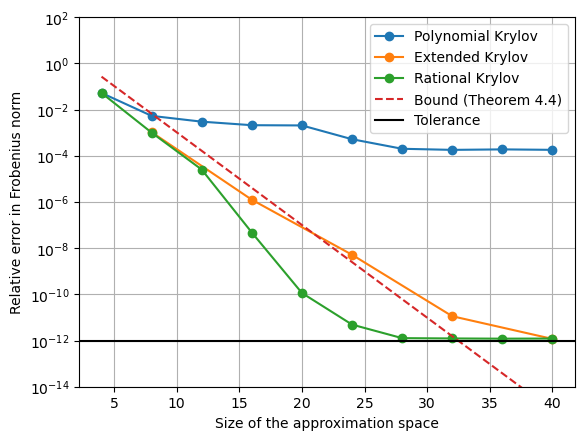

In [59]:
# Plot the results
fig = plt.figure()
plt.semilogy(krylov_space_size, krylov_error, 'o-', label="Polynomial Krylov")
plt.semilogy(extended_krylov_space_size, extended_krylov_error, 'o-', label="Extended Krylov")
plt.semilogy(rational_krylov_space_size, rational_krylov_error, 'o-', label="Rational Krylov")
plt.semilogy(rational_krylov_space_size, 100*bound, '--', label="Bound (Theorem 4.4)")
plt.axhline(1e-12, color='k', linestyle='-', label="Tolerance")
plt.xlabel("Size of the approximation space")
plt.ylabel("Relative error in Frobenius norm")
plt.ylim([1e-14, 1e2])
plt.grid()
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

## Krylov approximation error - Order two

### Setup the problem

In [60]:
# Imports
import numpy as np
import scipy.linalg as la
from problems import make_riccati_ostermann
from low_rank_toolbox import SVD, LowRankMatrix
import scipy.sparse.linalg as spala
import matplotlib.pyplot as plt
from krylov_toolbox import KrylovSpace, ExtendedKrylovSpace, RationalKrylovSpace


# Problem parameters
size = 200 # 200
q = 9 # 9
make_ode = lambda size: make_riccati_ostermann(size, q)
ode, X0 = make_ode(size)

# Krylov parameters
t_span = (0, 0.01) # (0, 0.01)
h = t_span[1] - t_span[0]
rank = 2 # rank of initial value
nb_krylov_iter = 10 # number of Krylov iterations (extended Krylov space will have size 2*nb_krylov_iter)

# Print the ode
print(ode)

# Preprocess the problem
if not isinstance(X0, LowRankMatrix):
    X0 = SVD.reduced_svd(X0)
invA = spala.splu(ode.A).solve
invB = spala.splu(ode.B).solve

# Closed-form solution
def closed_form_solver(h, A, B, Y0, PGY0, PGRK1_minus_PGY0):
    D = la.solve_sylvester(A, B, PGRK1_minus_PGY0.todense())
    D_hat = la.solve_sylvester(A*h, B*h, D)
    C = la.solve_sylvester(A, B, PGY0.todense())
    Z = Y0 + D_hat + C
    Z = spala.expm_multiply(A, Z, start=0, stop=h, num=2, endpoint=True)[-1]
    Z = spala.expm_multiply(B.T.conj(), Z.T.conj(), start=0, stop=h, num=2, endpoint=True)[-1].T.conj()
    Y1_full = Z - C - D_hat - D
    return Y1_full

Riccati ODE structure with 3 parameters.


### Full problem

In [61]:
# Data for order 1
A, Ad = ode.A, ode.A.todense()
B, Bd = ode.B, ode.B.todense()
Y0 = SVD.truncated_svd(X0, rank)
PGY0 = Y0.project_onto_tangent_space(ode.non_linear_field(0, Y0))

# Solve the full problem (order 1)
# full_ode = SylvesterOde(A, B, PGY0)
# K1 = solve_matrix_ivp(full_ode, t_span, Y0, solver='closed_form', dense_output=True)
C = la.solve_sylvester(Ad, Bd, PGY0.todense())
Z = Y0 + C
Z = spala.expm_multiply(A, Z, start=0, stop=h, num=2, endpoint=True)[-1]
Z = spala.expm_multiply(B.T.conj(), Z.T.conj(), start=0, stop=h, num=2, endpoint=True)[-1].T.conj()
K1 = Z - C

# Data for order 2
RK1 = SVD.truncated_svd(K1, rank)
GRK1 = ode.non_stiff_field(h, RK1)
PGRK1 = RK1.project_onto_tangent_space(GRK1)
PGRK1_minus_PGY0 = PGRK1 - PGY0

# Solve the full problem (order 2)
D = la.solve_sylvester(Ad, Bd, PGRK1_minus_PGY0.todense())
D_hat = la.solve_sylvester(Ad*h, Bd*h, D)
C = la.solve_sylvester(Ad, Bd, PGY0.todense())
Z = Y0 + D_hat + C
Z = spala.expm_multiply(A, Z, start=0, stop=h, num=2, endpoint=True)[-1]
Z = spala.expm_multiply(B.T.conj(), Z.T.conj(), start=0, stop=h, num=2, endpoint=True)[-1].T.conj()
Y1_full = Z - C - D_hat - D

### Reduced problem - Polynomial Krylov space

In [62]:
# Pre-allocate some variables
krylov_error = np.zeros(nb_krylov_iter)
krylov_space_size = np.zeros(nb_krylov_iter, dtype=int)

# Initialization of the two spaces
U = la.orth(np.column_stack([Y0.U, PGY0.U, PGRK1_minus_PGY0.U]))
left_krylov_space = KrylovSpace(A, U)
V = la.orth(np.column_stack([Y0.V, PGY0.V, PGRK1_minus_PGY0.V]))
right_krylov_space = KrylovSpace(B, V)

# Extract the two basis
Vk = left_krylov_space.Q
Wk = right_krylov_space.Q

# Reduced data
A_reduced = Vk.T.dot(A.dot(Vk))
B_reduced = Wk.T.dot(B.dot(Wk))
Y0_reduced = Y0.dot(Wk).dot(Vk.T, side='left')
PGY0_reduced = PGY0.dot(Wk).dot(Vk.T, side='left')
PGRK1_minus_PGY0_reduced = PGRK1_minus_PGY0.dot(Wk).dot(Vk.T, side='left')

# Solve the reduced problem
Zk = closed_form_solver(h, A_reduced, B_reduced, Y0_reduced, PGY0_reduced, PGRK1_minus_PGY0_reduced)
Y1_reduced = Vk.dot(Zk.dot(Wk.T))

# Compute the error and store the current size
krylov_error[0] = la.norm(Y1_full - Y1_reduced) / la.norm(Y1_full)
krylov_space_size[0] = left_krylov_space.Q.shape[1]
print("Iteration: k=0, size of space: {}, current error: {}".format(krylov_space_size[0], krylov_error[0]))

# Loop over the iterations
for i in np.arange(1, nb_krylov_iter):
    # Augment the two basis
    left_krylov_space.augment_basis()
    right_krylov_space.augment_basis()

    # Define the reduced problem ode
    Vk = left_krylov_space.Q
    Wk = right_krylov_space.Q
    
    # Reduced data
    A_reduced = Vk.T.dot(A.dot(Vk))
    B_reduced = Wk.T.dot(B.dot(Wk))
    Y0_reduced = Y0.dot(Wk).dot(Vk.T, side='left')
    PGY0_reduced = PGY0.dot(Wk).dot(Vk.T, side='left')
    PGRK1_minus_PGY0_reduced = PGRK1_minus_PGY0.dot(Wk).dot(Vk.T, side='left')

    # Solve the reduced problem
    Zk = closed_form_solver(h, A_reduced, B_reduced, Y0_reduced, PGY0_reduced, PGRK1_minus_PGY0_reduced)
    Y1_reduced = Vk.dot(Zk.dot(Wk.T))


    # Compute the error and store the current size
    krylov_error[i] = la.norm(Y1_full - Y1_reduced) / la.norm(Y1_full)
    krylov_space_size[i] = left_krylov_space.Q.shape[1]
    print("Iteration: k={}, size of space: {}, current error: {}".format(i, krylov_space_size[i], krylov_error[i]))

print("Done!")


Iteration: k=0, size of space: 8, current error: 0.0004358201464905876
Iteration: k=1, size of space: 16, current error: 4.323495212744709e-06
Iteration: k=2, size of space: 24, current error: 8.278333236359063e-08
Iteration: k=3, size of space: 32, current error: 7.875532663548698e-08
Iteration: k=4, size of space: 40, current error: 1.4809547286944885e-07
Iteration: k=5, size of space: 48, current error: 2.933079034056802e-07
Iteration: k=6, size of space: 56, current error: 6.600796389660436e-07
Iteration: k=7, size of space: 64, current error: 1.0629316637239696e-06
Iteration: k=8, size of space: 72, current error: 1.6273968150547874e-06
Iteration: k=9, size of space: 80, current error: 2.6301192791885125e-06
Done!


### Reduced problem - Extended Krylov space

In [63]:
# Pre-allocate some variables
nb_extended_krylov_iter = int(nb_krylov_iter/2)
extended_krylov_error = np.zeros(nb_extended_krylov_iter)
extended_krylov_space_size = np.zeros(nb_extended_krylov_iter, dtype=int)

# Preprocess the inverses
invA = spala.splu(ode.A).solve
invB = spala.splu(ode.B).solve

# Initialization of the two spaces
U = la.orth(np.column_stack([Y0.U, PGY0.U, PGRK1_minus_PGY0.U]))
left_extended_krylov_space = ExtendedKrylovSpace(A, U, invA=invA)
V = la.orth(np.column_stack([Y0.V, PGY0.V, PGRK1_minus_PGY0.V]))
right_extended_krylov_space = ExtendedKrylovSpace(B, V, invA=invB)

# Extract the two basis
Vk = left_extended_krylov_space.Q
Wk = right_extended_krylov_space.Q

# Reduced data
A_reduced = Vk.T.dot(A.dot(Vk))
B_reduced = Wk.T.dot(B.dot(Wk))
Y0_reduced = Y0.dot(Wk).dot(Vk.T, side='left')
PGY0_reduced = PGY0.dot(Wk).dot(Vk.T, side='left')
PGRK1_minus_PGY0_reduced = PGRK1_minus_PGY0.dot(Wk).dot(Vk.T, side='left')

# Solve the reduced problem
Zk = closed_form_solver(h, A_reduced, B_reduced, Y0_reduced, PGY0_reduced, PGRK1_minus_PGY0_reduced)
Y1_reduced = Vk.dot(Zk.dot(Wk.T))

# Compute the error and store the current size
extended_krylov_error[0] = la.norm(Y1_full - Y1_reduced) / la.norm(Y1_full)
extended_krylov_space_size[0] = left_extended_krylov_space.Q.shape[1]
print("Size of the Krylov space: {}".format(extended_krylov_space_size[0]))

# Loop over the iterations
for i in np.arange(1, nb_extended_krylov_iter):
    # Augment the two basis
    left_extended_krylov_space.augment_basis()
    right_extended_krylov_space.augment_basis()

    # Reduced data
    Vk = left_extended_krylov_space.Q
    Wk = right_extended_krylov_space.Q
    A_reduced = Vk.T.dot(A.dot(Vk))
    B_reduced = Wk.T.dot(B.dot(Wk))
    Y0_reduced = Y0.dot(Wk).dot(Vk.T, side='left')
    PGY0_reduced = PGY0.dot(Wk).dot(Vk.T, side='left')
    PGRK1_minus_PGY0_reduced = PGRK1_minus_PGY0.dot(Wk).dot(Vk.T, side='left')

    # Solve the reduced problem
    Zk = closed_form_solver(h, A_reduced, B_reduced, Y0_reduced, PGY0_reduced, PGRK1_minus_PGY0_reduced)
    Y1_reduced = Vk.dot(Zk.dot(Wk.T))

    # Compute the error and store the current size
    extended_krylov_error[i] = la.norm(Y1_full - Y1_reduced) / la.norm(Y1_full)
    extended_krylov_space_size[i] = left_extended_krylov_space.Q.shape[1]
    print("Iteration: k={}, size of space: {}, current error: {}".format(i, extended_krylov_space_size[i], extended_krylov_error[i]))

print("Done!")


Size of the Krylov space: 16
Iteration: k=1, size of space: 32, current error: 1.2424340049674729e-12
Iteration: k=2, size of space: 48, current error: 1.1951895379366918e-12
Iteration: k=3, size of space: 64, current error: 1.4376246343785557e-12
Iteration: k=4, size of space: 80, current error: 1.2926572932316049e-12
Done!


### Reduced problem - Rational Krylov space

In [64]:
# Pre-allocate some variables
rational_krylov_error = np.zeros(nb_krylov_iter)
rational_krylov_space_size = np.zeros(nb_krylov_iter, dtype=int)

# One repeated single pole: k/sqrt(2)
poles = [nb_krylov_iter/np.sqrt(2) for _ in range(nb_krylov_iter)]

# Initialization of the two spaces
U = la.orth(np.column_stack([Y0.U, PGY0.U, PGRK1_minus_PGY0.U]))
left_rational_krylov_space = RationalKrylovSpace(A, U, poles=poles)
V = la.orth(np.column_stack([Y0.V, PGY0.V, PGRK1_minus_PGY0.V]))
right_rational_krylov_space = RationalKrylovSpace(B, V, poles=poles)

# Extract the two basis
Vk = left_rational_krylov_space.Q
Wk = right_rational_krylov_space.Q

# Reduced data
A_reduced = Vk.T.dot(A.dot(Vk))
B_reduced = Wk.T.dot(B.dot(Wk))
Y0_reduced = Y0.dot(Wk).dot(Vk.T, side='left')
PGY0_reduced = PGY0.dot(Wk).dot(Vk.T, side='left')
PGRK1_minus_PGY0_reduced = PGRK1_minus_PGY0.dot(Wk).dot(Vk.T, side='left')

# Solve the reduced problem
Zk = closed_form_solver(h, A_reduced, B_reduced, Y0_reduced, PGY0_reduced, PGRK1_minus_PGY0_reduced)
Y1_reduced = Vk.dot(Zk.dot(Wk.T))

# Compute the error and store the current size
rational_krylov_error[0] = la.norm(Y1_full - Y1_reduced) / la.norm(Y1_full)
rational_krylov_space_size[0] = left_rational_krylov_space.Q.shape[1]
print("Size of the Krylov space: {}".format(rational_krylov_space_size[0]))

# Loop over the iterations
for i in np.arange(1, nb_krylov_iter):
    # Augment the two basis
    left_rational_krylov_space.augment_basis()
    right_rational_krylov_space.augment_basis()

    # Reduced data
    Vk = left_rational_krylov_space.Q
    Wk = right_rational_krylov_space.Q
    A_reduced = Vk.T.dot(A.dot(Vk))
    B_reduced = Wk.T.dot(B.dot(Wk))
    Y0_reduced = Y0.dot(Wk).dot(Vk.T, side='left')
    PGY0_reduced = PGY0.dot(Wk).dot(Vk.T, side='left')
    PGRK1_minus_PGY0_reduced = PGRK1_minus_PGY0.dot(Wk).dot(Vk.T, side='left')

    # Solve the reduced problem
    Zk = closed_form_solver(h, A_reduced, B_reduced, Y0_reduced, PGY0_reduced, PGRK1_minus_PGY0_reduced)
    Y1_reduced = Vk.dot(Zk.dot(Wk.T))

    # Compute the error and store the current size
    rational_krylov_error[i] = la.norm(Y1_full - Y1_reduced) / la.norm(Y1_full)
    rational_krylov_space_size[i] = left_rational_krylov_space.Q.shape[1]
    print("Iteration: k={}, size of space: {}, current error: {}".format(i, rational_krylov_space_size[i], rational_krylov_error[i]))

print("Done!")


Size of the Krylov space: 8
Iteration: k=1, size of space: 16, current error: 1.8233183643547158e-07
Iteration: k=2, size of space: 24, current error: 3.692540814536703e-12
Iteration: k=3, size of space: 32, current error: 1.1743058970472016e-12
Iteration: k=4, size of space: 40, current error: 1.0246758667677661e-12
Iteration: k=5, size of space: 48, current error: 1.553556683247812e-12
Iteration: k=6, size of space: 56, current error: 1.3469003835667593e-12
Iteration: k=7, size of space: 64, current error: 1.3907483320152266e-12
Iteration: k=8, size of space: 72, current error: 9.736016939161138e-13
Iteration: k=9, size of space: 80, current error: 1.4683900816481677e-12
Done!


### A priori bound (Theorem 4.5)

In [65]:
# Bound derived in the paper
def bound(k, t, A, B, Y0, PGY0):
    # Eigenvalues of A and B
    eigA = spala.eigs(A, return_eigenvectors=False)
    eigB = spala.eigs(B, return_eigenvectors=False)
    # Deltas
    deltaA = np.sqrt(np.max(np.abs(eigA)) / np.min(np.abs(eigA)))
    deltaB = np.sqrt(np.max(np.abs(eigB)) / np.min(np.abs(eigB)))
    delta = np.max([deltaA, deltaB])
    # Mus
    muA = np.max(eigA)
    muB = np.max(eigB)
    mu = np.max([muA, muB])
    # Norms
    norm_Y0 = Y0.norm()
    norm_PGY0 = PGY0.norm()
    norm_PGRK1_minus_PGY0 = PGRK1_minus_PGY0.norm()
    # Bound
    bd = 2 * np.exp(-k * np.pi**2 / (4*np.log(2/delta))) * (np.exp(t * mu) * norm_Y0 + (np.exp(t * mu) - 1)/mu * norm_PGY0 + (np.exp(t*mu) - 1 - t*mu)/(h*mu**2) * norm_PGRK1_minus_PGY0)
    return bd

bound = np.real(bound(np.arange(nb_krylov_iter), t_span[1], A, B, Y0, PGY0))

### Plot the results

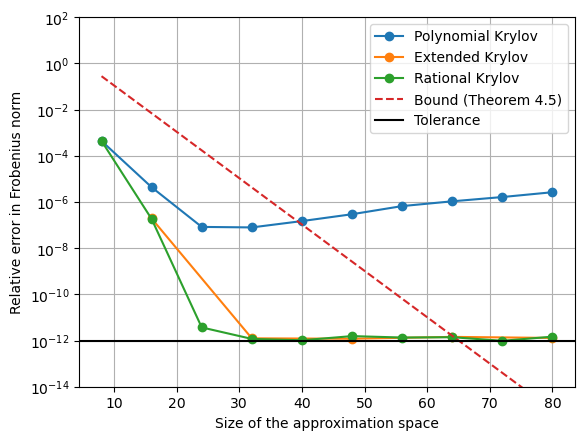

In [66]:
# Plot the results
fig = plt.figure()
plt.semilogy(krylov_space_size, krylov_error, 'o-', label="Polynomial Krylov")
plt.semilogy(extended_krylov_space_size, extended_krylov_error, 'o-', label="Extended Krylov")
plt.semilogy(rational_krylov_space_size, rational_krylov_error, 'o-', label="Rational Krylov")
plt.semilogy(rational_krylov_space_size, 100*bound, '--', label="Bound (Theorem 4.5)")
plt.axhline(1e-12, color='k', linestyle='-', label="Tolerance")
plt.xlabel("Size of the approximation space")
plt.ylabel("Relative error in Frobenius norm")
plt.ylim([1e-14, 1e2])
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()